In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as sio
import matplotlib
import scipy.optimize as opt
from sklearn.metrics import classification_report

In [2]:
def load_data(path, transpose=True):
    data = sio.loadmat(path)
    y = data.get('y')
    y = y.reshape(y.shape[0])
    
    X = data.get('X')
    
    if transpose:
        X = np.array([im.reshape((20, 20)).T for im in X])
        X = np.array([im.reshape(400) for im in X])
    
    return X,y

In [3]:
X, y = load_data('ex3data1.mat')
print(X.shape)
print(y.shape)

(5000, 400)
(5000,)


In [4]:
def plot_an_image(image):
#     image : (400,)
    fig, ax = plt.subplots(figsize=(1, 1))
    ax.matshow(image.reshape((20, 20)), cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
#绘图函数    

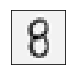

this should be 8


In [5]:
pick_one = np.random.randint(0, 5000)
plot_an_image(X[pick_one, :])
plt.show()
print('this should be {}'.format(y[pick_one]))

In [6]:
raw_X, raw_y = load_data('ex3data1.mat')
print(raw_X.shape)
print(raw_y.shape)

(5000, 400)
(5000,)


# 准备数据

In [7]:
X = np.insert(raw_X, 0, values=np.ones(raw_X.shape[0]), axis=1)
X.shape

(5000, 401)

In [8]:
y_matrix = []

for k in range(1, 11):
    y_matrix.append((raw_y == k).astype(int))
    
y_matrix = [y_matrix[-1]] + y_matrix[:-1]
y = np.array(y_matrix)

y.shape


(10, 5000)

In [10]:
y

array([[1, 1, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1]])

# train 1 model （训练一维模型）

In [11]:
def cost(theta, X, y):
    return np.mean(-y * log(sigmoid(X @ theta)) - (1 - y) * np.log(1 - sigmoid(X @ theta)))

In [12]:
def regularized_cost(theta, X, y, l=1):
    theta_j1_to_n = theta[1:]
    regularized_term = (1 / (2 * len(X))) * np.power(theta_j1_to_n,2).sum()
    
    return cost(theta, X, y) + regularized_term